# Data exploration 

### We will skip the downloading part since the data is already contained in the github repo

In this notebook, let us explore the dataset that we obtained from Kaggle.

I am assuming that most of you here have a Kaggle account. Provided you have a Kaggle account, you should be able to go ahead and download the data from here: https://www.kaggle.com/c/dog-breed-identification

For those of you who are familiar with using Kaggle API, here is a simple command to download the data: `kaggle competitions download -c dog-breed-identification`.

We will be using the training dataset only. [I am happy to come back for another session on hyperparameter tuning.]

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import pandas as pd

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\envs\ptorch\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [6]:
PATH = './dogbreed/'
label_csv = os.path.join(PATH, 'labels.csv')

Let us read the labels to see what the data has.

In [7]:
label_df = pd.read_csv(label_csv)
print(len(label_df))

10222


In [8]:
label_df.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


While we are at it, let us also see how many images belong to a particular class.

In [9]:
label_df['breed'].value_counts().head(20)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
airedale                107
tibetan_terrier         107
leonberg                106
cairn                   106
beagle                  105
japanese_spaniel        105
miniature_pinscher      102
blenheim_spaniel        102
australian_terrier      102
irish_wolfhound         101
Name: breed, dtype: int64

## Creating a subset of data

For training the entire dataset, this tutorial session is quite short. In the interest of time, I have extracted the dataset into two different sets.

1. **Binary classification**: subset of data where I have extracted 100 images from the top two breeds.
2. **Multiclass classification**: subset of data where I have extracted images from the top 10 breeds.

The goal is to make sure the training is fast and we don't incur huge $$$ cost for training.

### Binary classification

Looking at the statistics of the dogs above, the dogs that have the most samples are `scottish_deerhound` and `maltese_dog`. Let us extract it out to a smaller dataset.

PS: In a real-world like setting, this step is not essential. However, this is a tutorial on a Monday evening after a long day at work. So, let us make our lives easier! ;-)

## Data is already in github repository
You can skip this step since you already have the data

In [10]:
# scottish_df = label_df[label_df.breed == 'scottish_deerhound']
# train, val = train_test_split(scottish_df, test_size = 0.25)

# origin_path = './dogbreed/train/'
# train_path = './DogBreed/Binary/train/scottish/'
# val_path = './DogBreed/Binary/val/scottish/'

# if not os.path.exists(train_path):
#     os.makedirs(train_path)

# if not os.path.exists(val_path):
#     os.makedirs(val_path)

# for i, row in train.iterrows():
#     filename = row['id'] + '.jpg'
#     origin_file = os.path.join(origin_path, filename)
#     shutil.copy(origin_file, train_path)

# for i, row in val.iterrows():
#     filename = row['id'] + '.jpg'
#     origin_file = os.path.join(origin_path, filename)
#     shutil.copy(origin_file, val_path)

In [11]:
# maltese_df = label_df[label_df.breed == 'maltese_dog']
# train, val = train_test_split(maltese_df, test_size = 0.25)

# origin_path = './dogbreed/train/'
# train_path = './DogBreed/Binary/train/maltese/'
# val_path = './DogBreed/Binary/val/maltese/'

# if not os.path.exists(train_path):
#     os.makedirs(train_path)

# if not os.path.exists(val_path):
#     os.makedirs(val_path)

# for i, row in train.iterrows():
#     filename = row['id'] + '.jpg'
#     origin_file = os.path.join(origin_path, filename)
#     shutil.copy(origin_file, train_path)

# for i, row in val.iterrows():
#     filename = row['id'] + '.jpg'
#     origin_file = os.path.join(origin_path, filename)
#     shutil.copy(origin_file, val_path)

Obviously, it is common sense to not repeat code. So, let us extract this portion out to a function so that we can build a similar dataset for multiclass classification.

In [12]:
# def copy_to_folder(view, origin_path, destination_path):
#     for i, row in view.iterrows():
#         filename = row['id'] + '.jpg'
#         origin_file = os.path.join(origin_path, filename)
#         shutil.copy(origin_file, destination_path)

# breed_count_df = label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)
# breed_count_df.reset_index(level=0, inplace=True)

# breed_list = breed_count_df[:10]['breed'].values.tolist()

# origin_path = './dogbreed/train/'
# train_root = './DogBreed/Multiclass/train'
# validation_root = './DogBreed/Multiclass/val'
    
# for breed in breed_list:
#     breed_df = label_df[label_df['breed'] == breed]
#     train, val = train_test_split(breed_df, test_size = 0.25)
    
#     train_path = os.path.join(train_root, breed)
#     val_path = os.path.join(validation_root, breed)
    
#     if not os.path.exists(train_path):
#         os.makedirs(train_path)
    
#     if not os.path.exists(val_path):
#         os.makedirs(val_path)
    
#     copy_to_folder(train, origin_path, train_path)
#     copy_to_folder(train, origin_path, val_path)

A core component of any machine learning library or package is the ability to get data to the algorithm. `torch` is no different that way. So, let us see how to load the data and we can use it to visualize and understand the dataset. Thankfully, `torch` provides us with ready tools to do this easily.

First, let us look at the directory structure of the folder which contains the dataset to do our binary classification.

In [15]:
!dir .\\DogBreed\\Binary

 Volume in drive C is OS
 Volume Serial Number is 4ED7-D81B

 Directory of C:\Users\jj\OneDrive\Documents\GitHub\Intro-to-Image-Classification\DogBreed\Binary

09/10/2018  06:31 PM    <DIR>          .
09/10/2018  06:31 PM    <DIR>          ..
09/10/2018  06:31 PM    <DIR>          train
09/10/2018  06:31 PM    <DIR>          val
               0 File(s)              0 bytes
               4 Dir(s)  61,453,131,776 bytes free


The folder titled `Binary` contains two folders - `train` and `val`. Let us look at what these folders contain now.

In [16]:
!dir .\\DogBreed\\Binary\\train\\

 Volume in drive C is OS
 Volume Serial Number is 4ED7-D81B

 Directory of C:\Users\jj\OneDrive\Documents\GitHub\Intro-to-Image-Classification\DogBreed\Binary\train

09/10/2018  06:31 PM    <DIR>          .
09/10/2018  06:31 PM    <DIR>          ..
09/10/2018  06:31 PM    <DIR>          maltese
09/10/2018  06:31 PM    <DIR>          scottish
               0 File(s)              0 bytes
               4 Dir(s)  61,452,365,824 bytes free


As we see in a section of the code above, I extracted them into two separate folders -- `maltese` and `scottish`. `val` folder has similar structure as well. Now that we know, how our dataset looks like, let us try and load the data.

In [17]:
data_dir = './DogBreed/Binary/'

In [27]:
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms)
validation_image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms)

train_dataloader = torch.utils.data.DataLoader(train_image_dataset, shuffle=True, num_workers=4, batch_size=4)
validation_dataloader = torch.utils.data.DataLoader(validation_image_dataset, shuffle=True, num_workers=4, batch_size=4)

Let us look at how many images are there in the dataset. The nice thing about the `dataset` object in `torch` is that it gives a `__len__` attribute and an attribute called `__getitem__` that indexes the images.

In [28]:
print('Images in training dataset: ', len(train_image_dataset))
print('Images in validation dataset: ', len(validation_image_dataset))

Images in training dataset:  181
Images in validation dataset:  62


We know what classes we put in. However, it is good to double check to get the warm fuzzy feeling. ;-)

In [29]:
class_names = train_image_dataset.classes
print('Class names: ', class_names)

Class names:  ['maltese', 'scottish']


### Quiz 1

`train_dataloader` takes `train_image_dataset` with a `batch_size = 4`. What do you get when you call `len(train_dataloader)`?

In [22]:
len(train_dataloader)

46

### Quiz 2

What do you get when you call `len(validation_dataloader)`?

In [23]:
len(validation_dataloader)

16

### Quiz 3

What is the dimension of the tensor when you call `next(iter(train_dataloader))`?

Hint: Call the `.shape` attribute.

In [26]:
next(iter(train_dataloader))

[tensor([[[[-0.3712, -0.3541, -0.3369,  ..., -0.6109, -0.6281, -0.6109],
           [-0.4054, -0.4054, -0.3883,  ..., -0.5938, -0.6281, -0.6109],
           [-0.4568, -0.4568, -0.4397,  ..., -0.5767, -0.6109, -0.5938],
           ...,
           [-0.5938, -0.6965, -0.7308,  ..., -1.0904, -1.1589, -1.0562],
           [-0.5767, -0.5767, -0.6109,  ..., -1.0219, -1.2445, -1.2103],
           [-0.6281, -0.5767, -0.5424,  ..., -1.2103, -1.3473, -1.3987]],
 
          [[-0.0924, -0.0749, -0.0574,  ..., -0.3725, -0.3901, -0.3725],
           [-0.1275, -0.1275, -0.1099,  ..., -0.3550, -0.3901, -0.3725],
           [-0.1800, -0.1800, -0.1625,  ..., -0.3375, -0.3725, -0.3550],
           ...,
           [-0.1450, -0.2325, -0.2675,  ..., -0.6352, -0.7052, -0.6001],
           [-0.1099, -0.1099, -0.1450,  ..., -0.5651, -0.8102, -0.7752],
           [-0.1625, -0.1099, -0.0749,  ..., -0.8102, -0.9503, -1.0203]],
 
          [[-0.8633, -0.8458, -0.8284,  ..., -1.0376, -1.0550, -1.0376],
           [-

## Data visualization

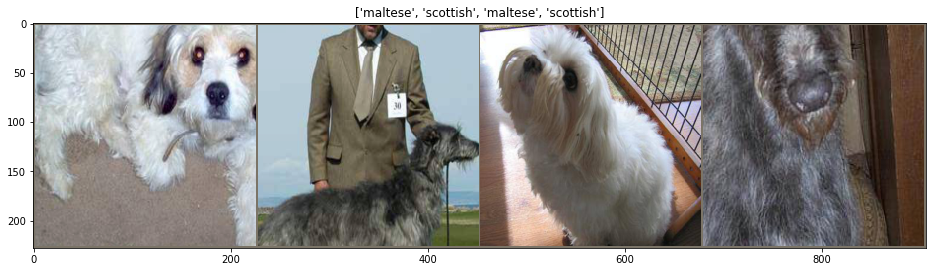

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in classes])